In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Import tsv data with header
df = pd.read_csv('data/final_datasets/aggregated_dataset.tsv', sep=';')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
# Create week column
df['week'] = pd.to_datetime(df['date']).dt.week
# Make week 52 to 0
df['week'] = df['week'].replace(52, 0)

<ipython-input-6-6f8e0d800fdd>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = pd.to_datetime(df['date']).dt.week


In [7]:
df.head()

,date,corpus,text_type,conflict,similarity,knowledge,power,status,support,identity,romance,trust,fun,High,Low,Mean,event_id,event_type,period_type,week
0,2022-03-06,sarn sauron coin bsc gem of 2022 launch now e...,post,0.217982,0.008616,0.987545,0.095460,0.210643,0.012049,0.401652,0.004092,8.436824e-07,0.404854,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
1,2022-03-06,a proposal to you removed,post,0.503045,0.435572,0.485023,0.518171,0.427520,0.495435,0.432057,0.254124,3.306695e-01,0.453298,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
2,2022-03-06,time to buy nan,post,0.315845,0.453668,0.491014,0.467255,0.453663,0.485220,0.443327,0.571401,4.674791e-01,0.595824,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
3,2022-03-06,stupid question please excuse my ignorance can...,post,0.685344,0.003814,0.995469,0.033478,0.095750,0.000713,0.207318,0.000114,8.855732e-07,0.099581,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
4,2022-03-06,bitcoin nan,post,0.488357,0.469591,0.483014,0.434496,0.515467,0.484323,0.482162,0.507920,5.038089e-01,0.523179,39640.176751,38211.647962,38925.912357,1.0,positive,before,9


In [27]:
def calculate_zscore(df, dimension, threshold = 0.5):
    f_scores = [] 
    # iterate over each week 
    for week in sorted(df['week'].unique()):

        # Count how many texts exceeds the threshold
        n_wihtin_dim = df[(df['week'] == week) & (df[dimension] > threshold)].shape[0]
        # Compute the fraction of texts that exceed the threshold
        f = n_wihtin_dim / df[df['week'] == week].shape[0]
        # Append the fraction to the list
        f_scores.append((week, f))

    # Compute the mean and standard deviation of the fractions
    mean = np.mean([f[1] for f in f_scores])
    std = np.std([f[1] for f in f_scores])

    # Compute the z-scores
    z_scores = [(f[0], (f[1] - mean) / std) for f in f_scores]
    return z_scores  

In [45]:
# Create a new dataframe with z-scores
z_scores = pd.DataFrame(columns = df.columns[3:13], index = sorted(df['week'].unique()))

for dimension in df.columns[3:13]:
    z_s = calculate_zscore(df, dimension)
    z_scores[dimension] = [z[1] for z in z_s]


In [60]:
# Make a date column from week index in the z-scores dataframe
import datetime
mondays = [datetime.datetime.strptime("2022-W" + str(int(w)) + '-1', "%Y-W%W-%w").date() for w in z_scores.index]
sundays = [datetime.datetime.strptime("2022-W" + str(int(w)) + '-0', "%Y-W%W-%w").date() for w in z_scores.index]
z_scores['date'] = [str(m) + ' - ' + str(s) for m, s in zip(mondays, sundays)]

,conflict,similarity,knowledge,power,status,support,identity,romance,trust,fun,date
0,-3.013080,0.063347,2.611241,-4.293999,0.058754,2.233962,-3.528539,-2.176769,0.492573,-2.195353,2021-12-27 - 2022-01-02
1,0.860803,1.281931,-0.164164,0.159261,0.718849,0.102100,-1.537784,1.673250,-1.311629,1.789169,2022-01-03 - 2022-01-09
2,0.359675,0.964453,-0.108456,0.342983,0.011036,0.550980,-0.336582,-0.504367,-0.533733,-0.156614,2022-01-10 - 2022-01-16
3,-0.267622,0.156060,-0.052747,-0.483769,-0.539485,0.415381,-0.413129,-0.791526,0.605815,0.188681,2022-01-17 - 2022-01-23
4,1.672259,0.278441,-0.853189,0.319249,0.184885,-0.681962,0.851603,-0.756261,-0.824636,0.154299,2022-01-24 - 2022-01-30


In [87]:
events = df[["date","event_type","period_type", "event_id"]].drop_duplicates().dropna()
# Group by event_type, period_type and event_id and make a date range

hep = events.groupby(["event_type","period_type", "event_id"]).agg({"date": [min, max]}).reset_index()
# make min and max date
hep["min_date"] = pd.to_datetime(hep["date"]["min"])
hep["max_date"] = pd.to_datetime(hep["date"]["max"])

# make a date range
hep["date_range"] = hep.apply(lambda x: str(x["min_date"].date()) + " - " +  str(x["max_date"].date())), axis=1)


# remove date, min_date and max_date columns
#hep = hep.drop(["date", "min_date", "max_date"], axis=1)
#print(hep)


In [91]:
print(hep["min_date"][0].date())

<class 'datetime.date'>


# Aske with rolling average

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dtale
import numpy as np

In [2]:
# Set threshold for binarizing labels
threshold = 0.7
num_days_rolling_average = 7

# Load in the aggregated dataset 
dataset_raw = pd.read_csv('data/final_datasets/aggregated_dataset.tsv',sep=';')

# Select subset of columns
dataset = dataset_raw[['date','High','Low','Mean','event_id','event_type','period_type']].drop_duplicates()

# Initialize dimensions 
dims = ['conflict','similarity','knowledge','power','status','support','identity','romance','trust','fun']

# Initialize dictionary with eventtype dataframes
corr_dfs = {}

# Events with no overlapping events as it complicates the analysis
events = dataset_raw[["date","event_type","period_type", "event_id"]].drop_duplicates(subset=["date"], keep="first").fillna("no_event")

/var/folders/ks/84b6fb594mg0n57lspnlf0nm0000gn/T/ipykernel_28347/2244728537.py:6: DtypeWarning:

Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
dataset_onehot = dataset_raw.copy()

# Iterate over dimensions and binarize based on the threshold defined in the top (for Bence)
for dim in dims:
    # Overwrites each dimension with a binary value
    dataset_onehot[dim] = dataset_onehot[dim].apply(lambda x:1  if x>threshold else 0)

In [9]:
# Group event posts by date (summed)
# Basically assigns a count of posts containing a given dimension for each day
cols = ['date']+dims+['Mean']
dataset_onehot = dataset_onehot[cols].groupby('date').mean().sort_index()

# Apply rolling average, essentially, iterating over the days,
# taking the average over the previous 3 days and 3 next days
# and assigning this value
# The first and last 3 days will be empty as they don't have enough preceding og succeeding days. 
#### These days are dropped
dataset_out = dataset_onehot.rolling(num_days_rolling_average,center=True).mean().dropna().sort_index()

# Create standard deviation dataframe for each dimension
dataset_out_sd = dataset_onehot.rolling(num_days_rolling_average,center=True).std().dropna().sort_index()

# Iterating over the dimensions, calculating the mean and std in order to calculate the z-score
# z_score(x) = (x-mean(X))/std(X)
for dim in dims:
    # Get mu
    mu = dataset_out[dim].mean()

    # Get std
    std = dataset_out[dim].std()

    # Check if any values over the threshold for a dimension - if not we would accidentally divide by zero
    # Only an issue for identity
    if std:
        # Calculate z-score and overwrite value for each dimension
        dataset_out[dim] = dataset_out[dim].apply(lambda x: (x-mu)/std)
        
    else:
        # Drop empty dimensions
        dataset_out.drop(dim,axis=1,inplace=True)
        print('Dropping',dim)

# Merge with standard deviation dataframe
dataset_out = dataset_out.merge(dataset_out_sd, on='date', suffixes=('', '_sd'), how='left')


# Merge with event data
dataset_out = dataset_out.merge(events, on='date', how='left')

Dropping identity


In [10]:
dataset_out.head()

,date,conflict,similarity,knowledge,power,status,support,romance,trust,fun,...,status_sd,support_sd,identity,romance_sd,trust_sd,fun_sd,Mean_sd,event_type,period_type,event_id
0,2022-01-05,0.145263,2.755013,0.226053,-1.338583,0.925392,1.664027,-0.398726,-1.273549,0.397240,...,0.003727,0.010386,0.0,0.001181,0.015420,0.020385,2380.968936,no_event,no_event,no_event
1,2022-01-06,0.180523,2.524149,-0.894038,-1.430295,0.847920,0.474451,-0.444392,-1.533154,0.532770,...,0.003780,0.007638,0.0,0.001220,0.011902,0.019632,2200.705331,no_event,no_event,no_event
2,2022-01-07,0.385185,2.679220,-0.743679,-1.467397,0.534513,0.373041,-0.629131,-1.498305,0.904548,...,0.004432,0.007420,0.0,0.001725,0.012027,0.017000,2021.037158,no_event,no_event,no_event
3,2022-01-08,0.521626,2.989361,-0.593320,-0.947970,0.534513,0.474451,-0.813871,-1.184665,1.028474,...,0.004432,0.007906,0.0,0.002041,0.011802,0.015459,1281.274161,no_event,no_event,no_event
4,2022-01-09,0.544366,2.795523,-0.142243,-0.985072,0.534513,0.068810,-0.998610,-1.184665,0.904548,...,0.004432,0.007754,0.0,0.002249,0.011802,0.016439,849.283796,no_event,no_event,no_event


# Plotting for periods

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the z_score dataset
dataset = pd.read_csv('data/final_datasets/FINAL_zscores.tsv',sep=';')

In [17]:
dataset.head()

,date,conflict,similarity,knowledge,power,status,support,romance,trust,fun,...,status_sd,support_sd,identity,romance_sd,trust_sd,fun_sd,Mean_sd,event_type,period_type,event_id
0,2022-01-05,0.145263,2.755013,0.226053,-1.338583,0.925392,1.664027,-0.398726,-1.273549,0.397240,...,0.003727,0.010386,0.0,0.001181,0.015420,0.020385,2380.968936,0,0,0
1,2022-01-06,0.180523,2.524149,-0.894038,-1.430295,0.847920,0.474451,-0.444392,-1.533154,0.532770,...,0.003780,0.007638,0.0,0.001220,0.011902,0.019632,2200.705331,0,0,0
2,2022-01-07,0.385185,2.679220,-0.743679,-1.467397,0.534513,0.373041,-0.629131,-1.498305,0.904548,...,0.004432,0.007420,0.0,0.001725,0.012027,0.017000,2021.037158,0,0,0
3,2022-01-08,0.521626,2.989361,-0.593320,-0.947970,0.534513,0.474451,-0.813871,-1.184665,1.028474,...,0.004432,0.007906,0.0,0.002041,0.011802,0.015459,1281.274161,0,0,0
4,2022-01-09,0.544366,2.795523,-0.142243,-0.985072,0.534513,0.068810,-0.998610,-1.184665,0.904548,...,0.004432,0.007754,0.0,0.002249,0.011802,0.016439,849.283796,0,0,0


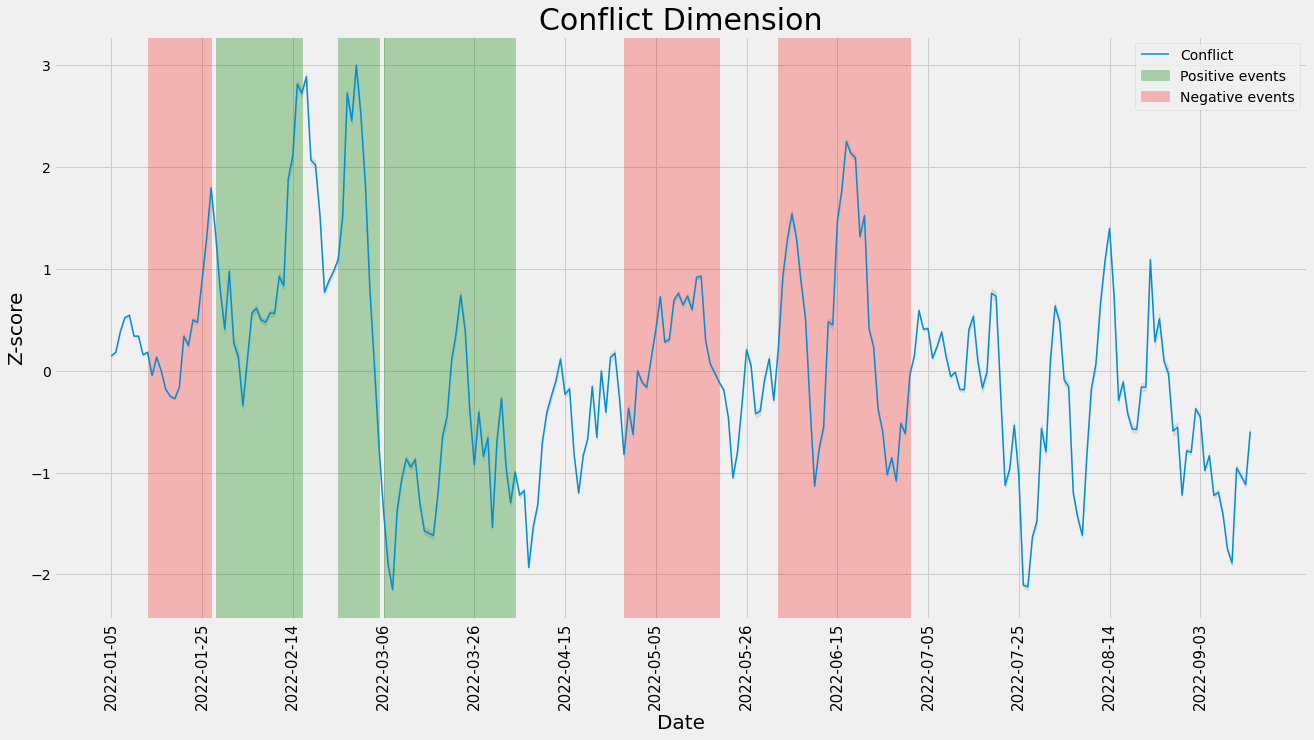

In [24]:
# Function for plotting a dimension
def plot_dim(dim):
    plt.figure(figsize=(20,10))
    plt.style.use('fivethirtyeight')
    # Plot the conflict dimension
    plt.plot(dataset['date'],dataset[dim], linewidth= 1.5, label = dim[0].upper() + dim[1:])

    # Plot the standard deviation as a shaded area - DOES NOT WORK
    plt.fill_between(dataset['date'], dataset[dim] - dataset[dim+'_sd'], dataset[dim] + dataset[dim+'_sd'], color = "#888888", alpha=0.2)

    # Make the plot readable
    plt.xticks(rotation=90)
    # Make x-axis ticks every 20 days
    plt.xticks(np.arange(0, len(dataset['date']), 20), size = 15)

    # Visualize event id 1, 2 and 3 as x-span
    for event_id in [1,2,3]:
        # Get the min and max date for the event
        min_date = dataset[(dataset['event_id']==event_id)]['date'].min()
        max_date = dataset[(dataset['event_id']==event_id)]['date'].max()
        if event_id == 1:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='green', alpha=0.3, label = "Positive events")
        else:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='green', alpha=0.3)

    # Visualize event id 4, 5 and 6 as x-span
    for event_id in [4,5,6]:
        # Get the min and max date for the event
        min_date = dataset[(dataset['event_id']==event_id)]['date'].min()
        max_date = dataset[(dataset['event_id']==event_id)]['date'].max()
        
        if event_id == 4:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='red', alpha=0.25, label = "Negative events")
        else:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='red', alpha=0.25)

    # Make dim with big letter
    dim = dim[0].upper() + dim[1:]

    # Create title with dim and bigger font
    plt.title(dim + " Dimension", fontsize=30)

    # Create legend with positve and negative events 
    plt.legend()

    # Make x and y axis labels
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Z-score", fontsize=20)

    plt.show()
    # Save figure
    #plt.savefig('viz/dimension_plots/z_score_'+dim+'.png')

plot_dim('conflict')

In [ ]:
dims = ['conflict','similarity','knowledge','power','status','support','romance','trust','fun']
# Plot dimensions side by side
for dim in dims:
    plot_dim(dim)
#plot_dim('conflict')

In [ ]:
# dimension columns
dims = ['conflict','similarity','knowledge','power','status','support','romance','trust','fun']